In [2]:
import os
import torch
import numpy as np
from datasets import load_dataset, Features, Sequence, Value
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

MODEL_NAME = "bert-base-uncased"

ds = load_dataset("NLBSE/nlbse25-code-comment-classification")


lang = "python" # for training I just swapped out the language for each model
train_set = ds[f"{lang}_train"]
test_set = ds[f"{lang}_test"]

print("Train columns:", train_set.column_names)
print("First training example:", train_set[0])

all_labels = set()
for label_list in train_set["labels"]:
    for label in label_list:
        all_labels.add(label)

all_labels = sorted(list(all_labels))
label2id = {label: idx for idx, label in enumerate(all_labels)}
id2label = {idx: label for label, idx in label2id.items()}

print("Unique labels extracted:", all_labels)
print("Label2ID mapping:", label2id)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess_examples(examples):
    encoding = tokenizer(
        examples["comment_sentence"], 
        truncation=True, 
        padding="max_length", 
        max_length=128, 
        return_tensors="pt"
    )

    multi_hot_labels = []
    for label_list in examples["labels"]:
        label_vec = torch.zeros(len(all_labels), dtype=torch.float32)
        for lbl in label_list:
            label_idx = label2id[lbl]
            label_vec[label_idx] = 1.0
        multi_hot_labels.append(label_vec)

    multi_hot_labels = torch.stack(multi_hot_labels)

    return {
        "input_ids": encoding["input_ids"],
        "attention_mask": encoding["attention_mask"],
        "labels": multi_hot_labels
    }

processed_train = train_set.map(preprocess_examples, batched=True, batch_size=32)
processed_test = test_set.map(preprocess_examples, batched=True, batch_size=32)

unused_columns = ['index', 'class', 'comment_sentence', 'partition', 'combo']
processed_train = processed_train.remove_columns(unused_columns)
processed_test = processed_test.remove_columns(unused_columns)

features = Features({
    "input_ids": Sequence(Value("int64")),
    "attention_mask": Sequence(Value("int64")),
    "labels": Sequence(Value("float32"))
})

processed_train = processed_train.cast(features)
processed_test = processed_test.cast(features)

processed_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
processed_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

print("Data preprocessing complete. Ready for model training.")

num_labels = len(all_labels)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    probs = 1 / (1 + np.exp(-predictions))
    preds = (probs > 0.5).astype(int)
    avg = "micro"
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=avg)
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_train,
    eval_dataset=processed_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Train columns: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels']
First training example: {'index': 1, 'class': 'AccessMixin', 'comment_sentence': 'functionality.', 'partition': 0, 'combo': 'functionality. | AccessMixin', 'labels': [0, 0, 0, 0, 1]}
Unique labels extracted: [0, 1]
Label2ID mapping: {0: 0, 1: 1}


Map:   0%|          | 0/406 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/406 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Data preprocessing complete. Ready for model training.


/Users/ryancblocker/.pyenv/versions/3.9.18/lib/python3.9/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/58/zwxktyh56bs0n0y924gcbr_w0000gn/T/ipykernel_84897/3625358242.py:115: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/1180 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 0.0012887378688901663, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 3.6124, 'eval_samples_per_second': 112.392, 'eval_steps_per_second': 7.198, 'epoch': 1.0}


  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 0.0006057982100173831, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 3.5306, 'eval_samples_per_second': 114.995, 'eval_steps_per_second': 7.364, 'epoch': 2.0}


  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 0.000392155401641503, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 3.5299, 'eval_samples_per_second': 115.016, 'eval_steps_per_second': 7.366, 'epoch': 3.0}


  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 0.00029024379909969866, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 3.6239, 'eval_samples_per_second': 112.034, 'eval_steps_per_second': 7.175, 'epoch': 4.0}
{'loss': 0.01, 'grad_norm': 0.005015821196138859, 'learning_rate': 2.88135593220339e-05, 'epoch': 4.24}


  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 0.00023310464166570455, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 3.9651, 'eval_samples_per_second': 102.392, 'eval_steps_per_second': 6.557, 'epoch': 5.0}


  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 0.0001979899825528264, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 3.6803, 'eval_samples_per_second': 110.317, 'eval_steps_per_second': 7.065, 'epoch': 6.0}


  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 0.0001753221295075491, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 3.5587, 'eval_samples_per_second': 114.085, 'eval_steps_per_second': 7.306, 'epoch': 7.0}


  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 0.0001609038736205548, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 3.5632, 'eval_samples_per_second': 113.944, 'eval_steps_per_second': 7.297, 'epoch': 8.0}
{'loss': 0.0002, 'grad_norm': 0.0030010042246431112, 'learning_rate': 7.627118644067798e-06, 'epoch': 8.47}


  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 0.00015275388432200998, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 3.6472, 'eval_samples_per_second': 111.318, 'eval_steps_per_second': 7.129, 'epoch': 9.0}


  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 0.00015003255975898355, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 3.5891, 'eval_samples_per_second': 113.12, 'eval_steps_per_second': 7.244, 'epoch': 10.0}
{'train_runtime': 613.025, 'train_samples_per_second': 30.733, 'train_steps_per_second': 1.925, 'train_loss': 0.004361982337372788, 'epoch': 10.0}


TrainOutput(global_step=1180, training_loss=0.004361982337372788, metrics={'train_runtime': 613.025, 'train_samples_per_second': 30.733, 'train_steps_per_second': 1.925, 'total_flos': 1239253070745600.0, 'train_loss': 0.004361982337372788, 'epoch': 10.0})

In [3]:
results = trainer.evaluate()
print("Evaluation Results:", results)

print("Final Test Accuracy:", results.get("eval_accuracy"))
print("Final Test Precision:", results.get("eval_precision"))
print("Final Test Recall:", results.get("eval_recall"))
print("Final Test F1-score:", results.get("eval_f1"))

  0%|          | 0/26 [00:00<?, ?it/s]

Evaluation Results: {'eval_loss': 0.00015003255975898355, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 3.5939, 'eval_samples_per_second': 112.969, 'eval_steps_per_second': 7.234, 'epoch': 10.0}
Final Test Accuracy: 1.0
Final Test Precision: 1.0
Final Test Recall: 1.0
Final Test F1-score: 1.0


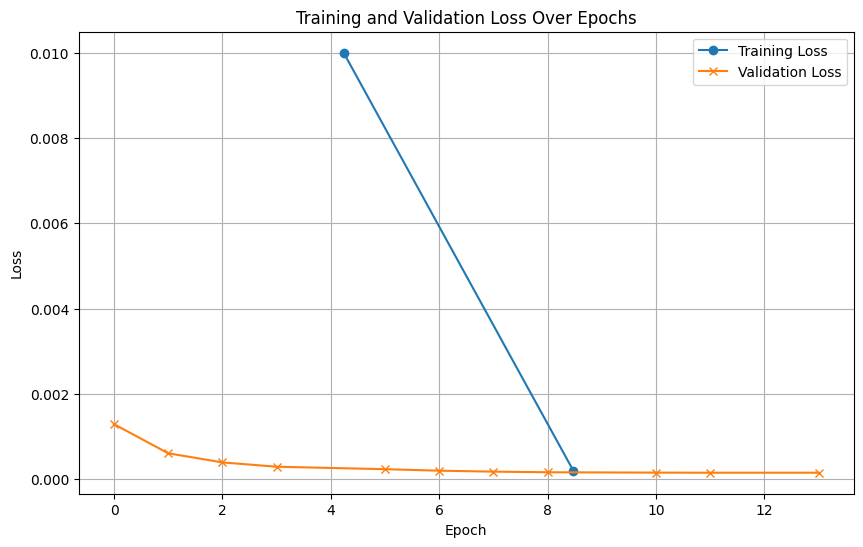

In [4]:
import matplotlib.pyplot as plt

# Extract training and evaluation loss from trainer's log history
train_loss = []
eval_loss = []
epochs = []

for log in trainer.state.log_history:
    if "loss" in log and "epoch" in log:
        train_loss.append(log["loss"])
        epochs.append(log["epoch"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])

# Plot Training and Evaluation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Training Loss", marker='o')
# eval_loss might have fewer points (one per evaluation), so we assume it corresponds to full epochs:
if len(eval_loss) == len(epochs):
    plt.plot(epochs, eval_loss, label="Validation Loss", marker='x')
else:
    # If eval is less frequent, just plot what we have
    eval_epochs = [ep for ep, log in enumerate(trainer.state.log_history) if "eval_loss" in log]
    plt.plot(eval_epochs, eval_loss, label="Validation Loss", marker='x')

plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
model.config.label2id = label2id
model.config.id2label = id2label

trainer.save_model("./python_model_epoch10")
tokenizer.save_pretrained("./python_model_epoch10")

('./python_model_epoch10/tokenizer_config.json',
 './python_model_epoch10/special_tokens_map.json',
 './python_model_epoch10/vocab.txt',
 './python_model_epoch10/added_tokens.json',
 './python_model_epoch10/tokenizer.json')